# Preparation

This project aims on using Deep Learning with Kullback-Leibler Divergence. Some basic packages are required for this project. The aim of the following chunk is to install required packages such as `lifelines`, `sklearn-pandas` and `torchtuples`. Note that `pycox` is built based on `torchtuples`.

---

`pycox` should be pre-installed and removed into the google drive since we need to modify part of the code in this package for our model. However in the tutorial, we can actually predefine our loss function outside the package, so this part need to be updated probably.


In [ ]:
!pwd
!pip install lifelines
! pip install sklearn-pandas
! pip install torchtuples
# ! pip install statsmodels
! pip install statsmodels --upgrade
# ! pip install pycox

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 349 kB 6.9 MB/s 
     |████████████████████████████████| 68 kB 2.5 MB/s 
     |████████████████████████████████| 38.1 MB 10.7 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=506f63375b38373dcc5df45c490abbef12712404f2cc67d3994d785eda5be9b4
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is inc

`pycox` is pre-installed in /content/drive/MyDrive/pycox, before that we need to track the data in google drive.

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

%cd "/content/drive/MyDrive/pycox"
# %pwd
# from pycox.models import LogisticHazard

Mounted at /content/drive
/content/drive/MyDrive/pycox


In [ ]:
import os
import sys

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch # For building the networks 
import torchtuples as tt # Some useful functions

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

In [ ]:
np.random.seed(1234)
_ = torch.manual_seed(1234)

If you have mounted the data rightly, you should print out the list for files in given folder. For example, this will print out all files in `/content/drive/My Drive/Kevin He`

In [ ]:
# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2022WI folder and put all the files under A4 folder, then "2022WI/A4"
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "Kevin He"
GOOGLE_DRIVE_PATH = os.path.join("/content/drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['local_data.csv', 'prior_data.csv', 'local_data_2.csv', 'local_data_3.csv', 'prior_data_subset.csv', 'prior_data_subset_2.csv', 'prior_data_subset_3.csv', 'R-code.ipynb', 'local_data_together.csv', 'Untitled', 'Deep Learning with KL Divergence Non-linear Visualization.ipynb', 'Deep Learning with KL Divergence Simulation Image Data.ipynb', 'Deep Learning with KL Divergence.ipynb', 'Deep Learning with KL Divergence Real Data.ipynb', 'prior_data_subset_4.csv', 'Deep Learning with KL Divergence Simulation 1: Tutorial', 'Deep Learning with KL Divergence Simulation Non-linear-prop.ipynb', 'Deep Learning with KL-divergence Real Data: Tutorial.ipynb', 'Deep Learning with KL Divergence Simulation 3: Tutorial.ipynb', 'Deep Learning with KL Divergence Simulation 2-1: Tutorial.ipynb']


# Simulate Non-linear and non-proportional Data

In this experiment, we want to generate non-linear and non-proportional data and show our results compared with Cox proportional hazard model and LogisticHazard. 

In [ ]:
import numpy as np
import pandas as pd

from pycox.simulations import base
from pycox.simulations import relative_risk

In [ ]:
Sim = relative_risk.SimStudyNonLinearNonPH()

data = Sim.simulate(10000)

In [ ]:
data

{'censor_durations': array([31.59328808,  6.73823818, 19.93173665, ..., 19.43694798,
        24.84352481, 38.89668595]),
 'censor_events': array([1., 1., 1., ..., 1., 1., 1.]),
 'covs': array([[-0.6169611 ,  0.24421754, -0.12454452],
        [ 0.57071716,  0.5599516 , -0.4548148 ],
        [-0.4470715 ,  0.6037443 ,  0.9162787 ],
        ...,
        [-0.27352798, -0.4161864 , -0.27053055],
        [ 0.18815653,  0.0567992 ,  0.44821537],
        [-0.7588893 , -0.33428824,  0.24114954]], dtype=float32),
 'durations': array([22.23264528,  6.73823818,  1.37836299, ..., 19.43694798,
         0.40366079,  2.0859419 ]),
 'durations_true': array([22.23264528,  8.7002544 ,  1.37836299, ..., 41.72885726,
         0.40366079,  2.0859419 ]),
 'events': array([ True, False,  True, ..., False,  True,  True]),
 'events_true': array([1., 1., 1., ..., 1., 1., 1.]),
 'surv_df': None}

In [ ]:
covs = pd.DataFrame(data['covs'], columns=['x1', 'x2', 'x3'])
covs['duration'] = data['durations']
covs['event'] = data['events']
def change(x):
  if(x == True):
    return 1
  else:
    return 0

covs['event'] = covs['event'].apply(lambda x: change(x))
covs

,x1,x2,x3,duration,event
0,-0.616961,0.244218,-0.124545,22.232645,1
1,0.570717,0.559952,-0.454815,6.738238,0
2,-0.447071,0.603744,0.916279,1.378363,1
3,0.751865,-0.284365,0.001990,0.545242,1
4,0.366926,0.425404,-0.259498,0.897150,0
...,...,...,...,...,...
9995,-0.575074,0.890978,-0.931862,23.183964,1
9996,-0.850644,0.933865,0.764328,2.781375,1
9997,-0.273528,-0.416186,-0.270531,19.436948,0
9998,0.188157,0.056799,0.448215,0.403661,1


# Cox v.s. LogisticHazard

In [ ]:
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

from lifelines import CoxPHFitter

In [ ]:
concordance_td_list_old = []
integrated_brier_score_list_old = []
integrated_nbll_list_old = []
concordance_td_list = []
integrated_brier_score_list = []
integrated_nbll_list = []

for i in range(20):
  df_train = covs.copy()

  num_durations = 20

  scheme = 'quantiles'
  labtrans = LogisticHazard.label_transform(num_durations, scheme)

  get_target = lambda df: (df['duration'].values, df['event'].values)
  y_train = labtrans.fit_transform(*get_target(df_train))
  df_train["duration"] = y_train[0]

  df_prior = df_train.sample(frac = 0.95)
  df_local = df_train.drop(df_prior.index)

  df_local_test = df_local.sample(frac=0.2)
  df_local_train = df_local.drop(df_local_test.index)

  cph = CoxPHFitter()
  cph.fit(df_local_train, duration_col = 'duration', event_col = 'event')
  # cph.check_assumptions(df_local_train, p_value_threshold = 0.05)

  # concordance_td_list_old.append(cph.score(df_local_test, scoring_method = "concordance_index"))

  surv = cph.predict_survival_function(df_local_test)

  ev = EvalSurv(surv, df_local_test['duration'].values, df_local_test['event'].values, censor_surv='km')
  
  concordance_td_list_old.append(ev.concordance_td('antolini'))
  time_grid = np.linspace(df_local_test['duration'].values.min(), df_local_test['duration'].values.max(), 100)
  integrated_brier_score_list_old.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_old.append((ev.integrated_nbll(time_grid)))

  df_local_val = df_local_train.sample(frac = 0.2)
  df_local_train = df_local_train.drop(df_local_val.index)

  cols_standardize =  ['x1', 'x2', 'x3']
  standardize = [([col], StandardScaler()) for col in cols_standardize]

  x_mapper_float = DataFrameMapper(standardize)

  x_train = x_mapper_float.fit_transform(df_local_train).astype('float32')
  x_val = x_mapper_float.transform(df_local_val).astype('float32')
  x_test = x_mapper_float.transform(df_local_test).astype('float32')

  get_target = lambda df: (df['duration'].values, np.array(df['event'].values, dtype = np.float32))
  y_train = get_target(df_local_train)
  y_val = get_target(df_local_val)

  durations_test, events_test = get_target(df_local_test)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = labtrans.out_features
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  model = LogisticHazard(net, tt.optim.Adam(0.01))

  batch_size = 20
  epochs = 300
  callbacks = [tt.callbacks.EarlyStopping()]
  verbose = False

  val = tt.tuplefy(x_val, y_val)

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                  val_data=val)
  
  surv = model.predict_surv_df(x_test)

  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  concordance_td_list.append(ev.concordance_td('antolini'))
  time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
  integrated_brier_score_list.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list.append((ev.integrated_nbll(time_grid)))

40

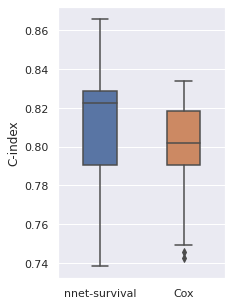

In [ ]:
import seaborn as sns

concordance_td_array = np.array(concordance_td_list)
concordance_td_array_old = np.array(concordance_td_list_old)
integrated_brier_score_array_old = np.array(integrated_brier_score_list_old)
integrated_brier_score_array = np.array(integrated_brier_score_list)
integrated_nbll_array = np.array(integrated_nbll_list)
integrated_nbll_array_old = np.array(integrated_nbll_list_old)

data = np.array(concordance_td_list + concordance_td_list_old)
label = ["nnet-survival" for i in range(len(concordance_td_array))] + ["Cox" for i in range(len(concordance_td_array_old))] # + ["Cox_50" for i in range(len(concordance_td_array_old))] + ["Cox_100" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"C-index": data, "Comparison w.r.t C-index": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t C-index', y='C-index', data=df, width = 0.4).set(xlabel = None)#.set(title = "Comparison w.r.t. IBLL")
len(data)


40

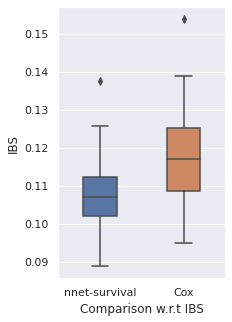

In [ ]:
data = np.array(integrated_brier_score_list + integrated_brier_score_list_old)
label = ["nnet-survival" for i in range(len(concordance_td_array))] + ["Cox" for i in range(len(concordance_td_array_old))] #+ ["Cox_50" for i in range(len(concordance_td_array_old))] + ["Cox_100" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"IBS": data, "Comparison w.r.t IBS": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t IBS', y='IBS', data=df, width = 0.4)#.set(title = "Comparison w.r.t. IBLL")
len(data)

# Our Model v.s. LogisticHazard

In [ ]:
concordance_td_list_new = []
integrated_brier_score_list_new = []
integrated_nbll_list_new = []

for i in range(20):
  df_train = covs.copy()

  num_durations = 20

  scheme = 'quantiles'
  labtrans = LogisticHazard.label_transform(num_durations, scheme)

  get_target = lambda df: (df['duration'].values, df['event'].values)
  y_train = labtrans.fit_transform(*get_target(df_train))
  df_train["duration"] = y_train[0]

  df_prior = df_train.sample(frac = 0.95)
  df_local = df_train.drop(df_prior.index)

  data_prior = df_prior.copy()

  data_prior_val = data_prior.sample(frac=0.2)
  data_prior_train = data_prior.drop(data_prior_val.index)

  cols_standardize =  ['x1', 'x2', 'x3']
  standardize = [([col], StandardScaler()) for col in cols_standardize]

  x_mapper_float = DataFrameMapper(standardize)

  x_train = x_mapper_float.fit_transform(data_prior_train).astype('float32')
  x_val = x_mapper_float.transform(data_prior_val).astype('float32')

  get_target = lambda df: (df['duration'].values, np.array(df['event'].values, dtype = np.float32))
  y_train = get_target(data_prior_train)
  y_val = get_target(data_prior_val)

  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  durations_test, events_test = get_target(df_local_test)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = labtrans.out_features
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

  batch_size = 20

  model.optimizer.set_lr(0.01)

  epochs = 512
  callbacks = [tt.callbacks.EarlyStopping()]
  verbose = False

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                  val_data=val)
  
  df_local = df_local.reset_index(drop = True)

  df_test = df_local.sample(frac=0.2)
  df_train = df_local.drop(df_test.index)
  df_val = df_train.sample(frac=0.2)
  df_train = df_train.drop(df_val.index)

  cols_standardize =  ['x1', 'x2', 'x3']
  standardize = [([col], StandardScaler()) for col in cols_standardize]

  x_mapper_float = DataFrameMapper(standardize)

  x_train = x_mapper_float.fit_transform(df_train).astype('float32')
  x_val = x_mapper_float.transform(df_val).astype('float32')
  x_test = x_mapper_float.transform(df_test).astype('float32')

  get_target = lambda df: (df['duration'].values, np.array(df['event'].values, dtype = np.float32))
  y_train = get_target(df_train)
  y_val = get_target(df_val)

  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  prior_info_train = model.predict_hazard(x_train)
  prior_info_val = model.predict_hazard(x_val)

  data_local_train_index = np.array(df_train.index)
  data_local_val_index = np.array(df_val.index)

  time = df_local["duration"]
  time = np.array(time).reshape(time.shape[0], -1)
  zeros = np.zeros((time.shape[0], 21))
  np.put_along_axis(zeros, time, np.array(df_local["event"]).reshape(-1, 1), axis=1)
  zeros = zeros[:, :-1]
  zeros

  zeros_train = zeros[data_local_train_index]
  zeros_val = zeros[data_local_val_index]

  eta = 20
  combined_info_train = (zeros_train + eta * prior_info_train) / (1 + eta)
  combined_info_val = (zeros_val + eta * prior_info_val) / (1 + eta)

  n_train = df_train.shape[0]
  n_val = df_val.shape[0]
  y_train = (combined_info_train, df_train['duration'].values, df_train['event'].values)
  y_val = (combined_info_val, df_val['duration'].values, df_val['event'].values)

  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  durations_test, events_test = get_target(df_test)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = labtrans.out_features
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts, loss = "option")

  batch_size = 20

  model.optimizer.set_lr(0.01)

  epochs = 512
  callbacks = [tt.callbacks.EarlyStopping()]
  verbose = False

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                  val_data=val)

  surv = model.predict_surv_df(x_test)

  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
  concordance_td_list_new.append(ev.concordance_td('antolini'))
  time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
  integrated_brier_score_list_new.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_new.append((ev.integrated_nbll(time_grid)))


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


60

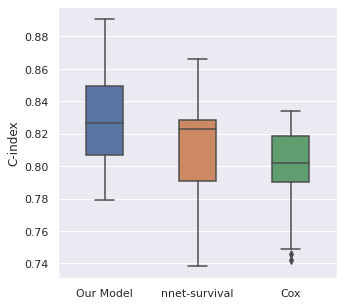

In [ ]:
# fig = plt.figure(figsize =(10, 7))
import seaborn as sns
# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width / 2, men_means, width, label='Men')
# rects2 = ax.bar(x + width / 2, women_means, width, label='Women')
# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()

# Creating plot
concordance_td_array_new = np.array(concordance_td_list_new)
concordance_td_array = np.array(concordance_td_list)
integrated_brier_score_array_new = np.array(integrated_brier_score_list_new)
integrated_brier_score_array = np.array(integrated_brier_score_list)
integrated_nbll_array_new = np.array(integrated_nbll_list_new)
integrated_nbll_array = np.array(integrated_nbll_list)

# data = np.array(concordance_td_list + concordance_td_list_old)
# label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
# df = pd.DataFrame({"C-index": data, "Models": label})

# sns.set(rc={'figure.figsize':(3,5)})
# sns.boxplot(x='Models', y='C-index', data=df, width = 0.4).set(title = "Comparison w.r.t. C-index")
# len(data)


# data = np.array(integrated_brier_score_list + integrated_brier_score_list_old)
# label = ["With KL" for i in range(len(integrated_brier_score_array))] + ["Without KL" for i in range(len(integrated_brier_score_array_old))]
# df = pd.DataFrame({"IBS": data, "Models": label})

# sns.set(rc={'figure.figsize':(3,5)})
# sns.boxplot(x='Models', y='IBS', data=df, width = 0.4).set(title = "Comparison w.r.t. IBS")
# len(data)

data = np.array(concordance_td_list_new + concordance_td_list + concordance_td_list_old)
label = ["Our Model" for i in range(len(concordance_td_array_new))] + ["nnet-survival" for i in range(len(concordance_td_array))] + ["Cox" for i in range(len(concordance_td_array))]
df = pd.DataFrame({"C-index": data, "Comparison w.r.t C-index": label})

sns.set(rc={'figure.figsize':(5,5)})
sns.boxplot(x='Comparison w.r.t C-index', y='C-index', data=df, width = 0.4).set(xlabel = None)#.set(title = "Comparison w.r.t. IBLL")
len(data)


# plt.boxplot([concordance_td_array, concordance_td_array_old])
# plt.title("Comparison w.r.t. C-index")
# plt.ylabel("C-index")
# show plot
# plt.show()

60

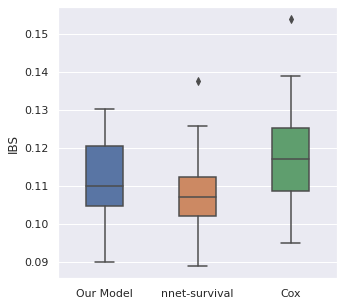

In [ ]:
data = np.array(integrated_brier_score_list_new + integrated_brier_score_list + integrated_brier_score_list_old)
label = ["Our Model" for i in range(len(concordance_td_array_new))] + ["nnet-survival" for i in range(len(concordance_td_array))] + ["Cox" for i in range(len(concordance_td_array))]
df = pd.DataFrame({"IBS": data, "Comparison w.r.t IBS": label})

sns.set(rc={'figure.figsize':(5,5)})
sns.boxplot(x='Comparison w.r.t IBS', y='IBS', data=df, width = 0.4).set(xlabel = None)#.set(title = "Comparison w.r.t. IBLL")
len(data)

60

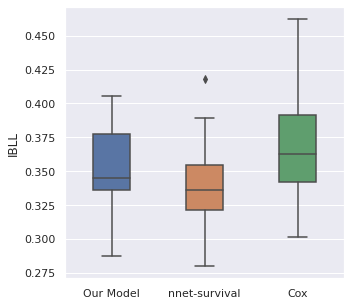

In [ ]:
data = np.array(integrated_nbll_list_new + integrated_nbll_list + integrated_nbll_list_old)
label = ["Our Model" for i in range(len(concordance_td_array_new))] + ["nnet-survival" for i in range(len(concordance_td_array))] + ["Cox" for i in range(len(concordance_td_array))]
df = pd.DataFrame({"IBLL": data, "Comparison w.r.t IBLL": label})

sns.set(rc={'figure.figsize':(5,5)})
sns.boxplot(x='Comparison w.r.t IBLL', y='IBLL', data=df, width = 0.4).set(xlabel = None)#.set(title = "Comparison w.r.t. IBLL")
len(data)